In [1]:
# 아이디어 1: 자전거 고장 빈도와 대여 빈도의 상관관계 분석
# 아이디어 2: 자전거 부품별 고장 빈도와 대여 빈도의 상관관계 분석
# 아이디어 3: 자전거 사용자의 연령대별 대여 패턴 분석

SyntaxError: invalid syntax (4117752079.py, line 1)

Aggregation completed and results stored in 'cycle_breakdown_rental_correlation' collection.


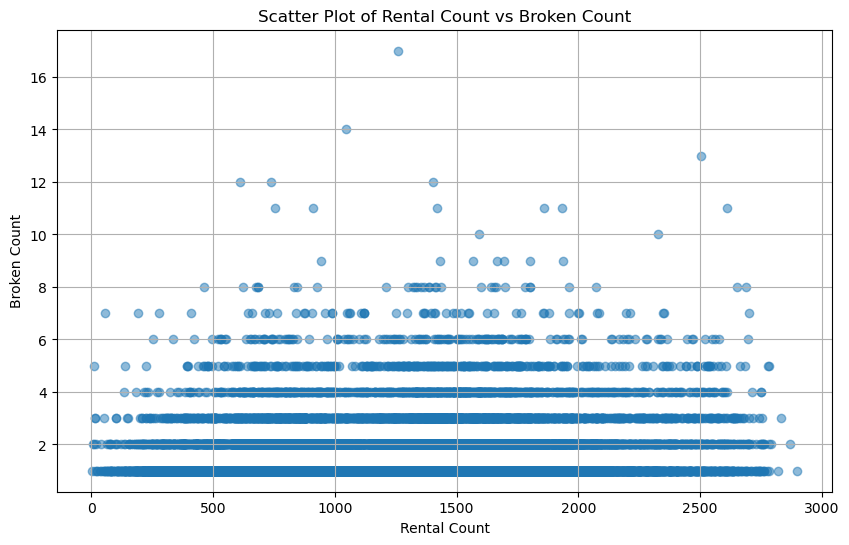

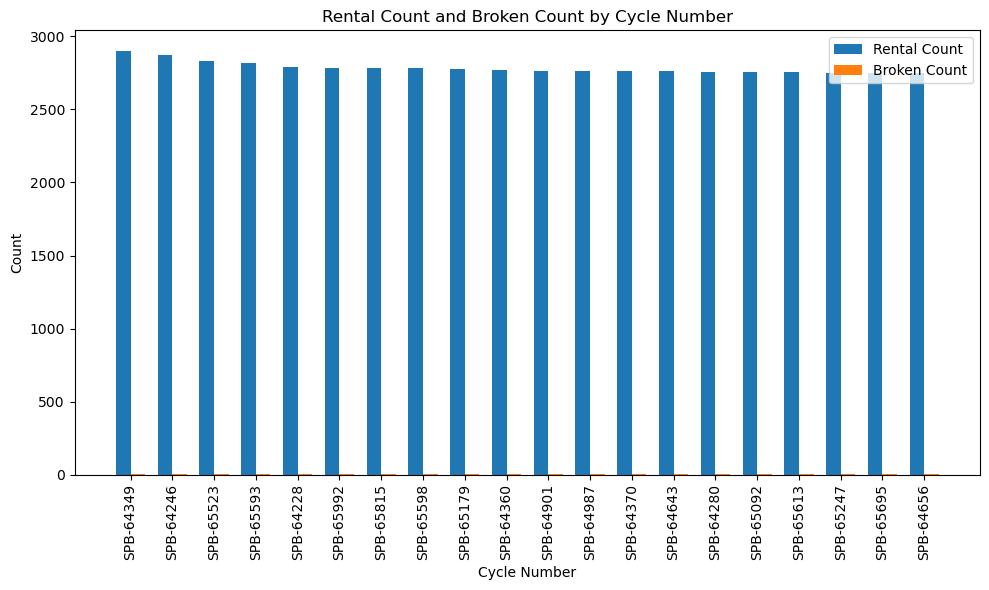

In [1]:
from pymongo import MongoClient, ASCENDING, DESCENDING
from pymongo.errors import ExecutionTimeout
import matplotlib.pyplot as plt
import pandas as pd


client = MongoClient('mongodb://localhost:27018/', serverSelectionTimeoutMS=5000)
db = client['cycle']

# 필요한 필드에 인덱스 추가
db.broken_history.create_index([('cycle_num', ASCENDING)])
db.rental_info.create_index([('cycle_num', ASCENDING)])

# Aggregation 파이프라인
pipeline = [
    {
        "$group": {
            "_id": "$cycle_num",
            "broken_count": { "$sum": 1 }
        }
    },
    {
        "$lookup": {
            "from": "rental_info",
            "localField": "_id",
            "foreignField": "cycle_num",
            "as": "rental_data"
        }
    },
    {
        "$unwind": "$rental_data"
    },
    {
        "$group": {
            "_id": "$_id",
            "broken_count": { "$first": "$broken_count" },
            "rental_count": { "$sum": 1 }
        }
    },
    {
        "$project": {
            "cycle_num": "$_id",
            "broken_count": 1,
            "rental_count": 1,
            "correlation": { "$divide": ["$broken_count", "$rental_count"] }
        }
    },
    {
        "$sort": { "rental_count": -1 }
    },
    {
        "$out": "cycle_breakdown_rental_correlation"
    }
]

# Aggregation 실행 및 결과 저장
try:
    db.broken_history.aggregate(pipeline, allowDiskUse=True, maxTimeMS=30000000)  # 타임아웃 시간을 5분으로 연장
    print("Aggregation completed and results stored in 'cycle_breakdown_rental_correlation' collection.")
except ExecutionTimeout:
    print("Aggregation query exceeded time limit")


In [2]:
from pymongo import MongoClient, ASCENDING, DESCENDING
from pymongo.errors import ExecutionTimeout
import matplotlib.pyplot as plt
import pandas as pd


client = MongoClient('mongodb://localhost:27017/', serverSelectionTimeoutMS=5000)
db = client['cycle']

# 필요한 필드에 인덱스 추가
db.broken_history.create_index([('cycle_num', ASCENDING), ('content', ASCENDING)])
db.rental_info.create_index([('cycle_num', ASCENDING)])

# Aggregation 파이프라인
pipeline = [
    {
        "$group": {
            "_id": { "cycle_num": "$cycle_num", "content": "$content" },
            "broken_count": { "$sum": 1 }
        }
    },
    {
        "$lookup": {
            "from": "rental_info",
            "localField": "_id.cycle_num",
            "foreignField": "cycle_num",
            "as": "rental_data"
        }
    },
    {
        "$unwind": "$rental_data"
    },
    {
        "$group": {
            "_id": { "cycle_num": "$_id.cycle_num", "content": "$_id.content" },
            "broken_count": { "$first": "$broken_count" },
            "rental_count": { "$sum": 1 }
        }
    },
    {
        "$project": {
            "cycle_num": "$_id.cycle_num",
            "content": "$_id.content",
            "broken_count": 1,
            "rental_count": 1,
            "correlation": { "$divide": ["$broken_count", "$rental_count"] }
        }
    },
    {
        "$sort": { "rental_count": -1 }
    },
    {
        "$out": "cycle_part_breakdown_correlation"
    }
]

# Aggregation 실행 및 결과 저장
try:
    db.broken_history.aggregate(pipeline, allowDiskUse=True, maxTimeMS=30000000)  # 타임아웃 시간을 5분으로 연장
    print("Aggregation completed and results stored in 'cycle_part_breakdown_correlation' collection.")
except ExecutionTimeout:
    print("Aggregation query exceeded time limit")

KeyboardInterrupt: 

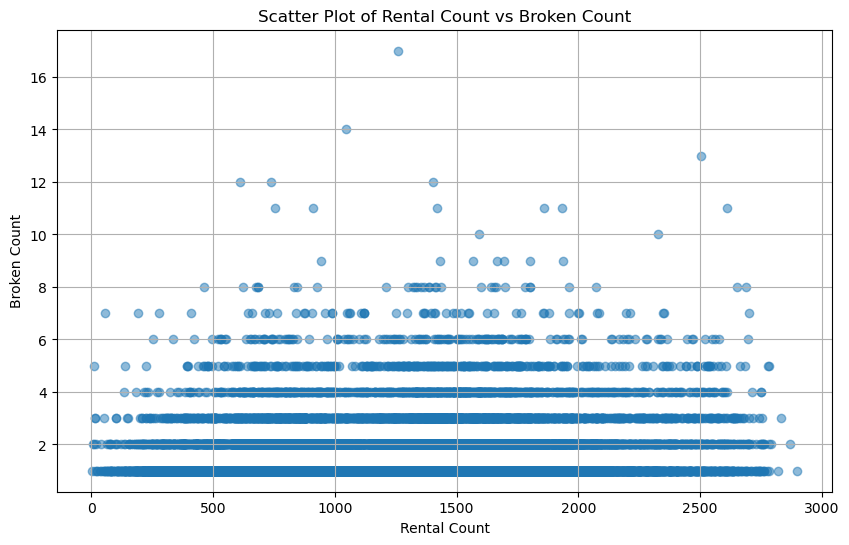

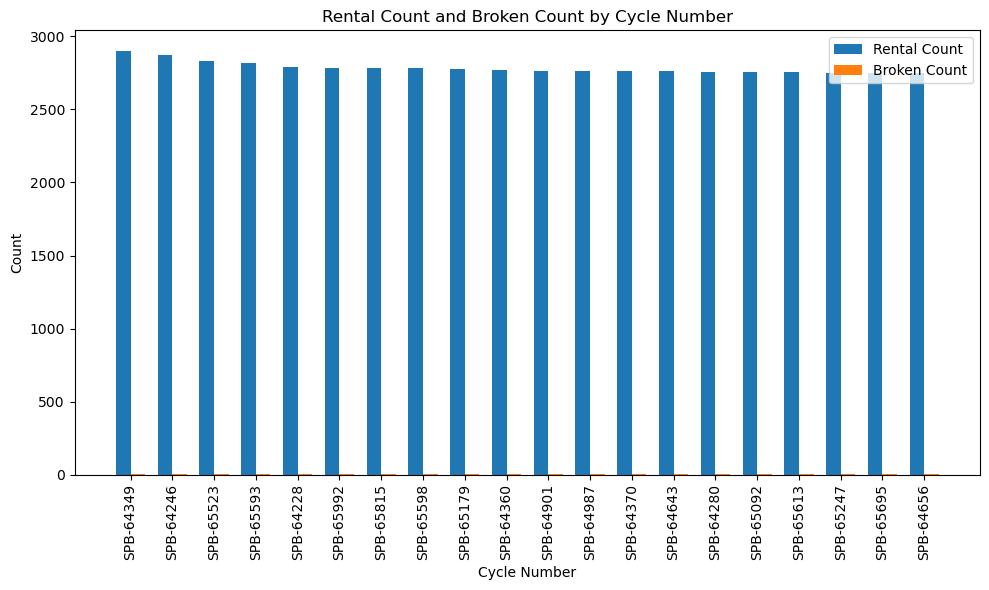

In [8]:
from pymongo import MongoClient, ASCENDING, DESCENDING
import matplotlib.pyplot as plt
import pandas as pd

client = MongoClient('mongodb://localhost:27018/', serverSelectionTimeoutMS=5000)
db = client['cycle']

# 저장된 결과를 불러와서 시각화
try:
    result = list(db.cycle_breakdown_rental_correlation.find())
    # 결과를 DataFrame으로 변환
    df = pd.DataFrame(result)
    
    # 산점도 시각화
    plt.figure(figsize=(10, 6))
    plt.scatter(df['rental_count'], df['broken_count'], alpha=0.5)
    plt.title('Scatter Plot of Rental Count vs Broken Count')
    plt.xlabel('Rental Count')
    plt.ylabel('Broken Count')
    plt.grid(True)
    plt.show()

    # 막대 그래프 시각화
    df_sorted = df.sort_values(by='rental_count', ascending=False).head(20)  # 상위 20개의 자전거만 표시
    fig, ax = plt.subplots(figsize=(10, 6))
    bar_width = 0.35
    index = range(len(df_sorted))

    bar1 = plt.bar(index, df_sorted['rental_count'], bar_width, label='Rental Count')
    bar2 = plt.bar([i + bar_width for i in index], df_sorted['broken_count'], bar_width, label='Broken Count')

    plt.xlabel('Cycle Number')
    plt.ylabel('Count')
    plt.title('Rental Count and Broken Count by Cycle Number')
    plt.xticks([i + bar_width / 2 for i in index], df_sorted['cycle_num'], rotation=90)
    plt.legend()
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Data retrieval or visualization error: {e}")


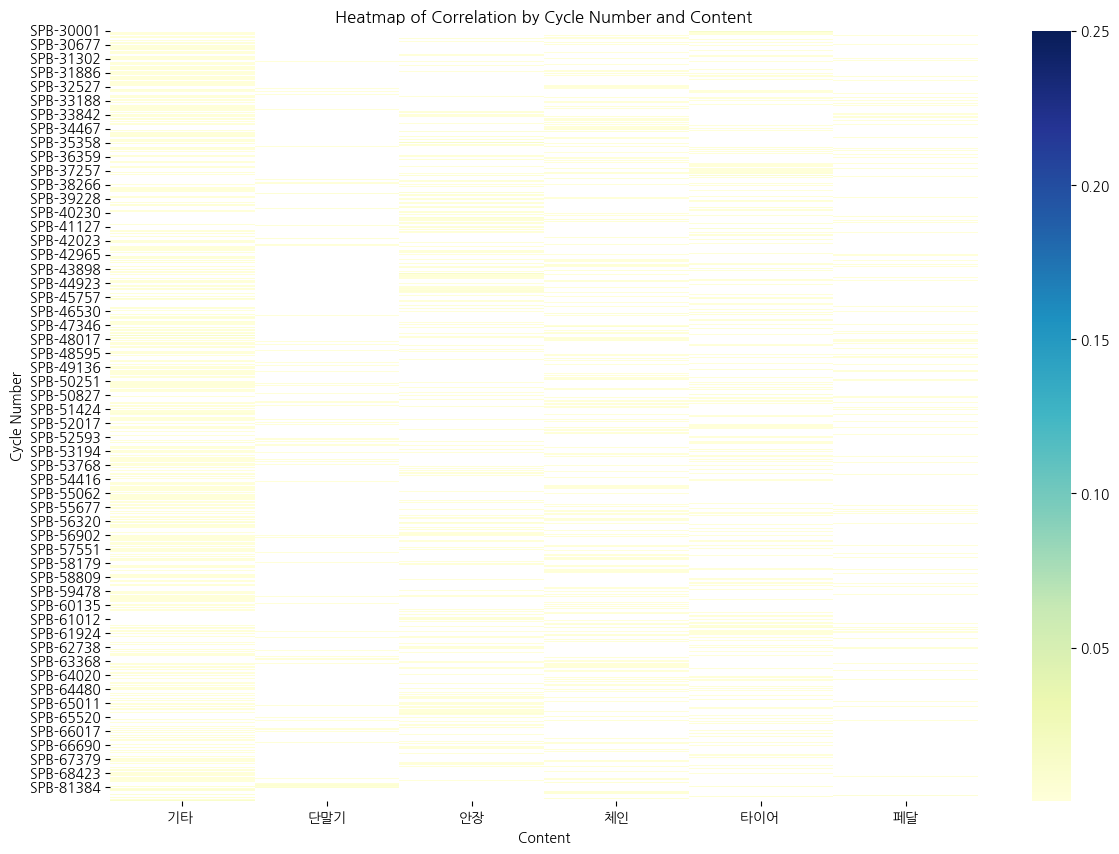

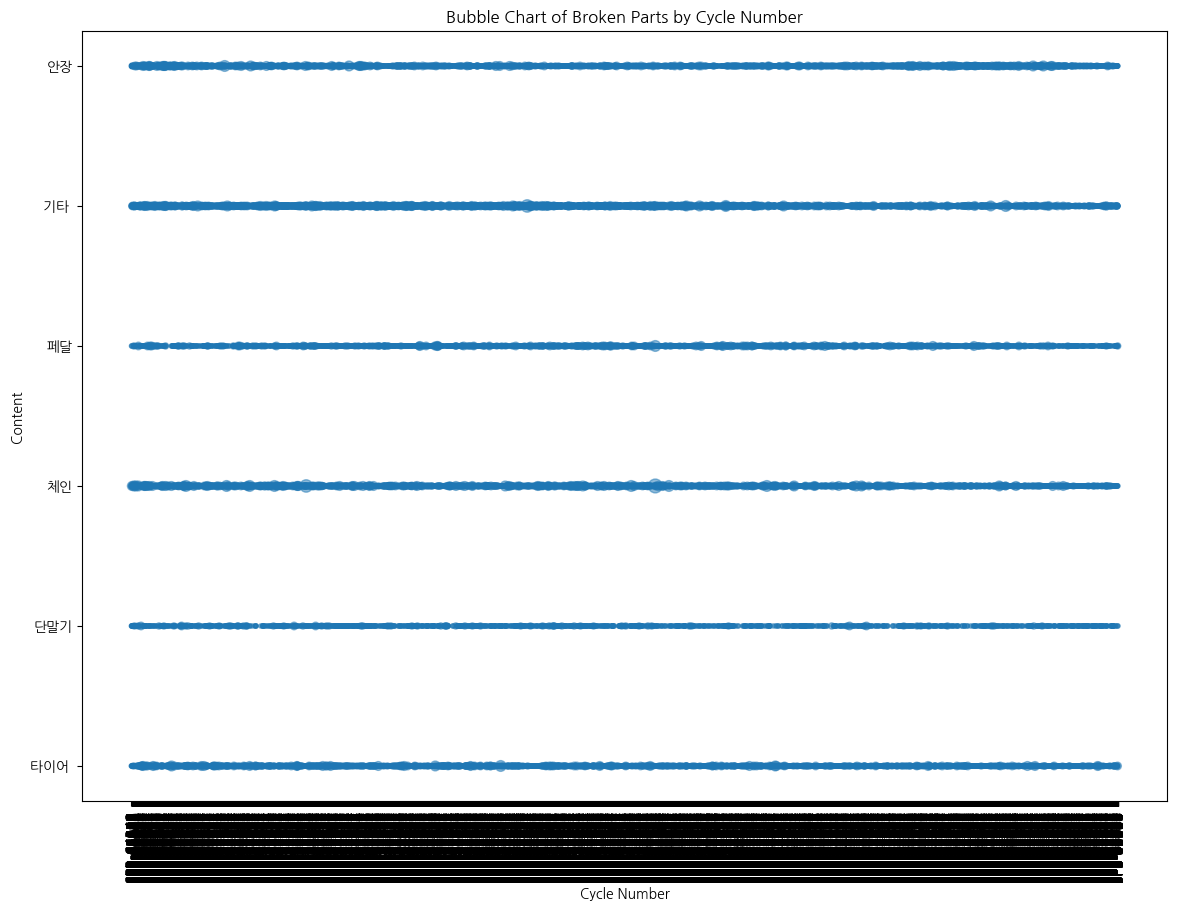

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x1383cf7e0> (for post_execute), with arguments args (),kwargs {}:


ValueError: Image size of 1200x1311000 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 1200x1311000 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1200x1.311e+06 with 14255 Axes>

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import plotly.express as px
from pymongo import MongoClient

# MongoDB 클라이언트 설정
client = MongoClient('mongodb://localhost:27018/')
db = client['cycle']

# 데이터 불러오기
df = pd.DataFrame(list(db.cycle_part_breakdown_correlation.find()))

# 1. 히트맵 (Heatmap)
plt.figure(figsize=(14, 10))
pivot_table = df.pivot(index='cycle_num', columns='content', values='correlation')
sns.heatmap(pivot_table, cmap='YlGnBu', annot=False)
plt.title('Heatmap of Correlation by Cycle Number and Content')
plt.xlabel('Content')
plt.ylabel('Cycle Number')
plt.show()

# 2. 버블 차트 (Bubble Chart)
plt.figure(figsize=(14, 10))
plt.scatter(df['cycle_num'], df['content'], s=df['broken_count']*10, alpha=0.5)
plt.title('Bubble Chart of Broken Parts by Cycle Number')
plt.xlabel('Cycle Number')
plt.ylabel('Content')
plt.xticks(rotation=90)
plt.show()

# 3. 라인 플롯 (Line Plot) with Facets
g = sns.FacetGrid(df, col='cycle_num', col_wrap=4, height=3)
g.map(sns.lineplot, 'content', 'correlation')
plt.show()

# 4. 패럴렐 카테고리 다이어그램 (Parallel Categories Diagram)
fig = px.parallel_categories(df, dimensions=['cycle_num', 'content', 'correlation'])
fig.show()

# 5. 밀도 플롯 (Density Plot)
plt.figure(figsize=(14, 7))
sns.kdeplot(data=df, x='cycle_num', hue='content', fill=True)
plt.title('Density Plot of Broken Parts by Cycle Number')
plt.xlabel('Cycle Number')
plt.ylabel('Density')
plt.show()
